In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [16]:
engine = create_engine("sqlite:///Resources_hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [65]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
#First determine what data is in the tables
inspector= inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


![precipitation](Images/precipitation.png)

In [66]:
columns=inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
#Get the last date of entry
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [25]:
#Retrieve last 12 months of precipitation data, but display only last 10 entries
Alldata=session.query(Measurement.id,Measurement.station,Measurement.date,Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date>"2016-08-23").order_by(Measurement.date.desc()).limit(10).all()
for data in Alldata:
    print(data)

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)
(7635, 'USC00514830', '2017-08-23', 0.0, 82.0)
(12187, 'USC00519523', '2017-08-23', 0.08, 82.0)
(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)
(2723, 'USC00519397', '2017-08-22', 0.0, 82.0)
(12186, 'USC00519523', '2017-08-22', 0.0, 82.0)
(19549, 'USC00516128', '2017-08-22', 0.5, 76.0)
(2722, 'USC00519397', '2017-08-21', 0.0, 81.0)
(7634, 'USC00514830', '2017-08-21', 0.02, 79.0)
(12185, 'USC00519523', '2017-08-21', None, 82.0)


In [28]:
# Calculate the date 1 year ago from the last data point in the database
# Note: this appears to be a requirement in the starter notebook but is not requested in the homework instructions
import datetime as dt
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [73]:
# Perform a query to retrieve the date and precipitation values
measdata=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>query_date).order_by(Measurement.date.desc()).all()


In [74]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf=pd.DataFrame(measdata,columns=["date", "precipitation"])
precipdf.set_index(precipdf["date"])
precipdf.head()

,date,precipitation
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


In [75]:
# Sort the dataframe by date
precipdf.sort_values(by=["date"],ascending=True,inplace=True)
precipdf.head()

,date,precipitation
2222,2016-08-24,1.45
2216,2016-08-24,0.08
2217,2016-08-24,2.15
2221,2016-08-24,2.15
2219,2016-08-24,NaN


<function matplotlib.pyplot.show(*args, **kw)>

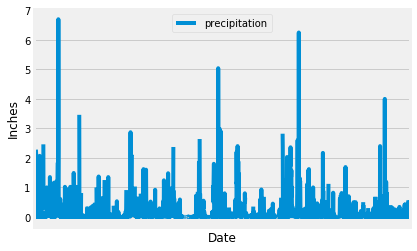

In [76]:
# Use Pandas Plotting with Matplotlib to plot the data
chart=prcpdf.plot(x="date", y="precipitation")
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Inches")
chart.legend(loc='upper center')
plt.show

In [77]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipdf.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

STATION ANALYSIS

In [78]:
# Design a query to show total number of stations in the dataset
session.query(Station.station).count()

9

In [37]:
# Query to find the most active stations (i.e. what stations have the most rows)
# List the stations and observation counts in descending order to find station with the greatest amount of observations
stations=session.query(Measurement.station,func.count(Measurement.id)).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
#Note: This query was found in the starter notebook but does not appear to be required in the homework instructions
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
USC281_query=engine.execute('Select min(tobs), max(tobs),avg(tobs) from Measurement where station="USC00519281"').fetchall()
USC281_stats=USC281_query[0]
USC281_stats

(54.0, 85.0, 71.66378066378067)

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobsdata=engine.execute('SELECT date, tobs FROM Measurement WHERE station="USC00519281" and date> "2016-08-23"').fetchall()
#tobsdata
tobsdata_df=pd.DataFrame(tobsdata)
tobsdata_df.head()
tobsdata_df=tobsdata_df.rename(columns={0:'date', 1:'tobs'})
tobsdata_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


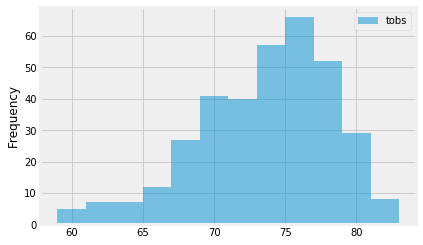

In [87]:
tobsdata_df.plot.hist(bins=12,alpha=.5)


![precipitation](Images/station-histogram.png)

CLIMATE APP

In [ ]:
#Design a FLASK API based on the queries just developed, use FLASK to create the routes using VS...

In [58]:
####NOTE: The calc_temps analysis is listed as optional in the homework instructions and was therefore attempted
#      but not necessarily completed

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [60]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


([<matplotlib.axis.YTick at 0x15f512ee0f0>,
 <a list of 6 Text yticklabel objects>)

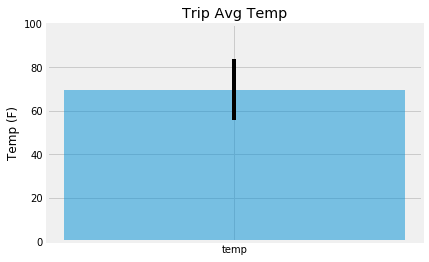

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_stats=calc_temps('2011-02-28', '2011-03-05')
trip_yaxis=trip_stats[0][1]
trip_min=trip_stats[0][0]
trip_max=trip_stats[0][2]
error=[trip_max-trip_min]

plt.bar("temp",trip_yaxis,alpha=.5,align="center",yerr=error,width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0,110,20))

In [63]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
precip_query=engine.execute('Select measurement.station, name, latitude, longitude, elevation, AVG(prcp) from measurement \
left join station on measurement.station=station.station \
where date between "2011-02-28" and "2011-03-05" group by measurement.station order by avg(prcp) desc').fetchall()
precip_query


[('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


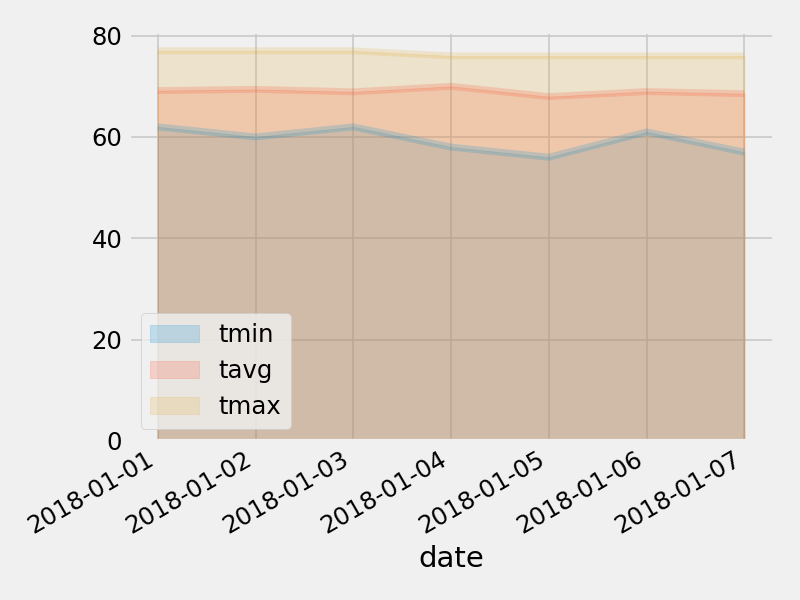

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
